# Penn Treebank (PTB) Dataset - Exploratory Data Analysis

This notebook provides a comprehensive analysis of the Penn Treebank dataset prepared for language modeling tasks.

## Overview
- **Dataset**: Penn Treebank Wall Street Journal corpus
- **Task**: Language modeling preparation and analysis
- **Splits**: Standard train/validation/test (sections 02-21/22/23)
- **Format**: Plain text with sentence boundaries marked by `<eos>` tokens

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

## 1. Data Loading and Basic Statistics

In [2]:
# Define data paths
data_dir = Path('../data/ptb')
train_file = data_dir / 'ptb.train.txt'
valid_file = data_dir / 'ptb.valid.txt'
test_file = data_dir / 'ptb.test.txt'

# Load the datasets
def load_data(filepath):
    """Load text data from file and return as list of sentences."""
    with open(filepath, 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f if line.strip()]
    return sentences

print("Loading Penn Treebank datasets...")
train_sentences = load_data(train_file)
valid_sentences = load_data(valid_file)
test_sentences = load_data(test_file)

print(f"✓ Train: {len(train_sentences):,} sentences")
print(f"✓ Valid: {len(valid_sentences):,} sentences")
print(f"✓ Test: {len(test_sentences):,} sentences")
print(f"✓ Total: {len(train_sentences) + len(valid_sentences) + len(test_sentences):,} sentences")

Loading Penn Treebank datasets...
✓ Train: 2,000 sentences
✓ Valid: 100 sentences
✓ Test: 100 sentences
✓ Total: 2,200 sentences


In [3]:
# Create dataset statistics summary
def get_text_stats(sentences):
    """Calculate comprehensive statistics for a list of sentences."""
    # Basic counts
    num_sentences = len(sentences)
    all_words = []
    sentence_lengths = []
    
    for sentence in sentences:
        words = sentence.split()
        all_words.extend(words)
        sentence_lengths.append(len(words))
    
    num_words = len(all_words)
    unique_words = len(set(all_words))
    
    # Calculate statistics
    stats = {
        'sentences': num_sentences,
        'total_words': num_words,
        'unique_words': unique_words,
        'vocabulary_size': unique_words,
        'avg_sentence_length': np.mean(sentence_lengths),
        'median_sentence_length': np.median(sentence_lengths),
        'min_sentence_length': np.min(sentence_lengths),
        'max_sentence_length': np.max(sentence_lengths),
        'std_sentence_length': np.std(sentence_lengths),
        'type_token_ratio': unique_words / num_words if num_words > 0 else 0
    }
    
    return stats, all_words, sentence_lengths

# Calculate statistics for each split
train_stats, train_words, train_lengths = get_text_stats(train_sentences)
valid_stats, valid_words, valid_lengths = get_text_stats(valid_sentences)
test_stats, test_words, test_lengths = get_text_stats(test_sentences)

# Create summary dataframe
stats_df = pd.DataFrame({
    'Train': train_stats,
    'Validation': valid_stats,
    'Test': test_stats
})

print("\n📊 Dataset Statistics Summary:")
print("=" * 50)
display(stats_df.round(2))


📊 Dataset Statistics Summary:


,Train,Validation,Test
sentences,2000.00,100.00,100.00
total_words,1025863.00,60017.00,56924.00
unique_words,46071.00,8475.00,8443.00
vocabulary_size,46071.00,8475.00,8443.00
avg_sentence_length,512.93,600.17,569.24
median_sentence_length,289.50,264.50,416.50
min_sentence_length,27.00,44.00,28.00
max_sentence_length,3951.00,3128.00,1994.00
std_sentence_length,517.82,650.64,474.31
type_token_ratio,0.04,0.14,0.15


## 2. Sample Text Exploration

In [4]:
# Display sample sentences from each split
print("📝 Sample Sentences from Each Split:")
print("=" * 60)

print("\n🚂 TRAINING SET (first 5 sentences):")
for i, sentence in enumerate(train_sentences[:5], 1):
    # Truncate long sentences for display
    display_sentence = sentence[:100] + "..." if len(sentence) > 100 else sentence
    print(f"{i:2d}. {display_sentence}")

print("\n✅ VALIDATION SET (first 3 sentences):")
for i, sentence in enumerate(valid_sentences[:3], 1):
    display_sentence = sentence[:100] + "..." if len(sentence) > 100 else sentence
    print(f"{i:2d}. {display_sentence}")

print("\n🧪 TEST SET (first 3 sentences):")
for i, sentence in enumerate(test_sentences[:3], 1):
    display_sentence = sentence[:100] + "..." if len(sentence) > 100 else sentence
    print(f"{i:2d}. {display_sentence}")

📝 Sample Sentences from Each Split:

🚂 TRAINING SET (first 5 sentences):
 1. In an Oct. 19 review of `` The Misanthrope '' at Chicago 's Goodman Theatre ( `` Revitalized Classic...
 2. Rolls-Royce Motor Cars Inc. said it expects its U.S. sales to remain steady at about 1,200 cars in 1...
 3. BELL INDUSTRIES Inc. increased its quarterly to 10 cents from seven cents a share . The new rate wil...
 4. Investors are appealing to the Securities and Exchange Commission not to limit their access to infor...
 5. The nation 's largest pension fund , which oversees $ 80 billion for college employees , plans to of...

✅ VALIDATION SET (first 3 sentences):
 1. Influential members of the House Ways and Means Committee introduced legislation that would restrict...
 2. We 're about to see if advertising works . Hard on the heels of Friday 's 190-point stock-market plu...
 3. You know what the law of averages is , do n't you ? It 's what 1 ) explains why we are like , well ,...

🧪 TEST SET (first 3 sen

## 3. Sentence Length Distribution Analysis

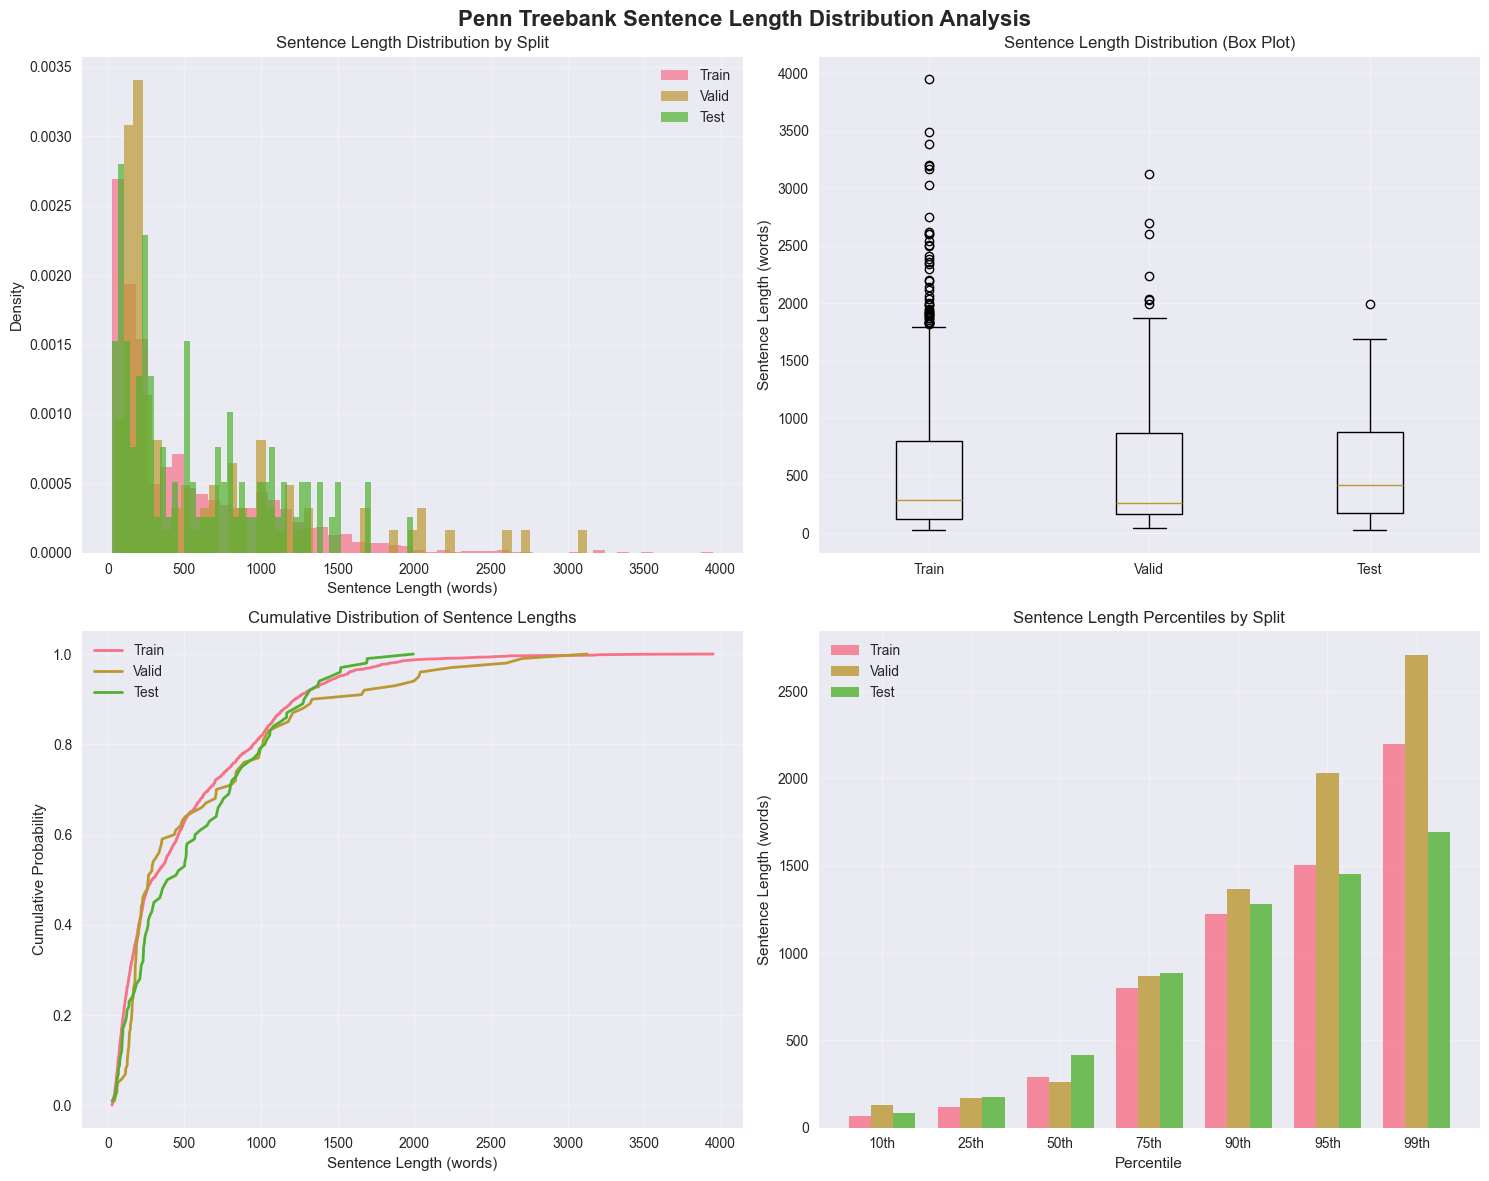


📏 Detailed Sentence Length Statistics:


,Metric,Train,Valid,Test
0,Min,27.0,44.0,28.0
1,Q1 (25%),121.0,167.8,177.8
2,Median,289.5,264.5,416.5
3,Q3 (75%),800.2,870.2,884.5
4,Max,3951.0,3128.0,1994.0
5,95th Percentile,1505.2,2029.5,1454.3
6,99th Percentile,2199.0,2706.3,1696.0


In [5]:
# Create comprehensive sentence length analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Penn Treebank Sentence Length Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Histogram comparison
axes[0, 0].hist(train_lengths, bins=50, alpha=0.7, label='Train', density=True)
axes[0, 0].hist(valid_lengths, bins=50, alpha=0.7, label='Valid', density=True)
axes[0, 0].hist(test_lengths, bins=50, alpha=0.7, label='Test', density=True)
axes[0, 0].set_xlabel('Sentence Length (words)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Sentence Length Distribution by Split')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot comparison
length_data = [train_lengths, valid_lengths, test_lengths]
axes[0, 1].boxplot(length_data, labels=['Train', 'Valid', 'Test'])
axes[0, 1].set_ylabel('Sentence Length (words)')
axes[0, 1].set_title('Sentence Length Distribution (Box Plot)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Cumulative distribution
for lengths, label in zip([train_lengths, valid_lengths, test_lengths], 
                         ['Train', 'Valid', 'Test']):
    sorted_lengths = np.sort(lengths)
    cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
    axes[1, 0].plot(sorted_lengths, cumulative, label=label, linewidth=2)

axes[1, 0].set_xlabel('Sentence Length (words)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].set_title('Cumulative Distribution of Sentence Lengths')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Length percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
train_percentiles = [np.percentile(train_lengths, p) for p in percentiles]
valid_percentiles = [np.percentile(valid_lengths, p) for p in percentiles]
test_percentiles = [np.percentile(test_lengths, p) for p in percentiles]

x_pos = np.arange(len(percentiles))
width = 0.25

axes[1, 1].bar(x_pos - width, train_percentiles, width, label='Train', alpha=0.8)
axes[1, 1].bar(x_pos, valid_percentiles, width, label='Valid', alpha=0.8)
axes[1, 1].bar(x_pos + width, test_percentiles, width, label='Test', alpha=0.8)

axes[1, 1].set_xlabel('Percentile')
axes[1, 1].set_ylabel('Sentence Length (words)')
axes[1, 1].set_title('Sentence Length Percentiles by Split')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'{p}th' for p in percentiles])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed length statistics
print("\n📏 Detailed Sentence Length Statistics:")
print("=" * 50)
length_stats_df = pd.DataFrame({
    'Metric': ['Min', 'Q1 (25%)', 'Median', 'Q3 (75%)', 'Max', '95th Percentile', '99th Percentile'],
    'Train': [
        np.min(train_lengths),
        np.percentile(train_lengths, 25),
        np.median(train_lengths),
        np.percentile(train_lengths, 75),
        np.max(train_lengths),
        np.percentile(train_lengths, 95),
        np.percentile(train_lengths, 99)
    ],
    'Valid': [
        np.min(valid_lengths),
        np.percentile(valid_lengths, 25),
        np.median(valid_lengths),
        np.percentile(valid_lengths, 75),
        np.max(valid_lengths),
        np.percentile(valid_lengths, 95),
        np.percentile(valid_lengths, 99)
    ],
    'Test': [
        np.min(test_lengths),
        np.percentile(test_lengths, 25),
        np.median(test_lengths),
        np.percentile(test_lengths, 75),
        np.max(test_lengths),
        np.percentile(test_lengths, 95),
        np.percentile(test_lengths, 99)
    ]
})

display(length_stats_df.round(1))

## 4. Vocabulary Analysis

In [6]:
# Comprehensive vocabulary analysis
print("🔤 Vocabulary Analysis:")
print("=" * 40)

# Calculate word frequencies for each split
train_word_freq = Counter(train_words)
valid_word_freq = Counter(valid_words)
test_word_freq = Counter(test_words)

# Combined vocabulary
all_words = train_words + valid_words + test_words
combined_word_freq = Counter(all_words)

print(f"📚 Vocabulary Sizes:")
print(f"  • Train: {len(train_word_freq):,} unique words")
print(f"  • Valid: {len(valid_word_freq):,} unique words")
print(f"  • Test: {len(test_word_freq):,} unique words")
print(f"  • Combined: {len(combined_word_freq):,} unique words")

# Vocabulary overlap analysis
train_vocab = set(train_words)
valid_vocab = set(valid_words)
test_vocab = set(test_words)

# Calculate overlaps
train_valid_overlap = len(train_vocab & valid_vocab) / len(valid_vocab) * 100
train_test_overlap = len(train_vocab & test_vocab) / len(test_vocab) * 100
valid_test_overlap = len(valid_vocab & test_vocab) / len(test_vocab) * 100

print(f"\n🔄 Vocabulary Overlap with Training Set:")
print(f"  • Valid set coverage: {train_valid_overlap:.1f}%")
print(f"  • Test set coverage: {train_test_overlap:.1f}%")

# Out-of-vocabulary (OOV) analysis
valid_oov = valid_vocab - train_vocab
test_oov = test_vocab - train_vocab

print(f"\n❌ Out-of-Vocabulary (OOV) Words:")
print(f"  • Valid set OOV: {len(valid_oov):,} words ({100 - train_valid_overlap:.1f}%)")
print(f"  • Test set OOV: {len(test_oov):,} words ({100 - train_test_overlap:.1f}%)")

if len(valid_oov) > 0:
    print(f"\n  Sample Valid OOV words: {list(valid_oov)[:10]}")
if len(test_oov) > 0:
    print(f"  Sample Test OOV words: {list(test_oov)[:10]}")

🔤 Vocabulary Analysis:
📚 Vocabulary Sizes:
  • Train: 46,071 unique words
  • Valid: 8,475 unique words
  • Test: 8,443 unique words
  • Combined: 48,233 unique words

🔄 Vocabulary Overlap with Training Set:
  • Valid set coverage: 86.6%
  • Test set coverage: 87.4%

❌ Out-of-Vocabulary (OOV) Words:
  • Valid set OOV: 1,135 words (13.4%)
  • Test set OOV: 1,068 words (12.6%)

  Sample Valid OOV words: ['reunions', 'savior', 'pendulum', 'hobbies', "'Cause", 'Burdett', 'inter-bank', 'correspondingly', 'Dowie', 'Rebounding']
  Sample Test OOV words: ['nibbling', 'Ashwood', 'Viren', '4,393,237', 'gentile', 'reunions', 'strangeness', 'AgResource', 'pendulum', 'global-news']


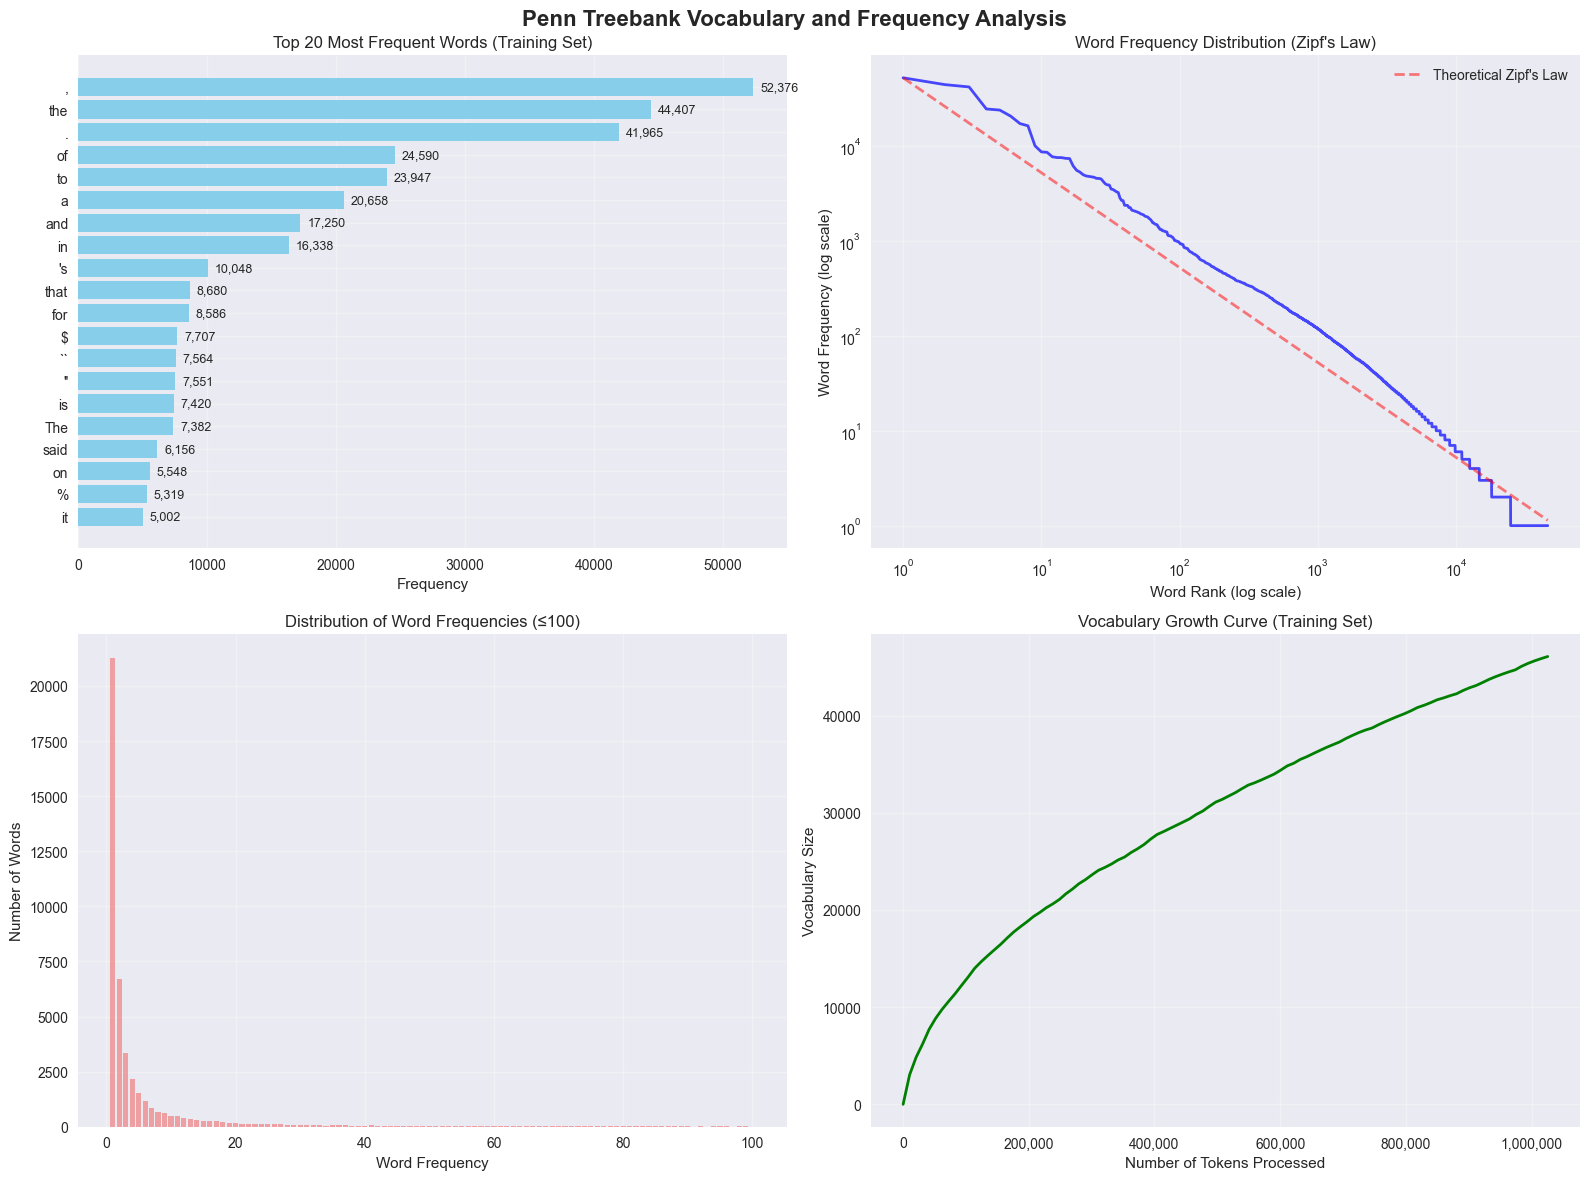

In [7]:
# Word frequency analysis and visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Penn Treebank Vocabulary and Frequency Analysis', fontsize=16, fontweight='bold')

# 1. Most common words in training set
top_words = train_word_freq.most_common(20)
words, counts = zip(*top_words)

axes[0, 0].barh(range(len(words)), counts, color='skyblue')
axes[0, 0].set_yticks(range(len(words)))
axes[0, 0].set_yticklabels(words)
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_title('Top 20 Most Frequent Words (Training Set)')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3)

# Add frequency labels
for i, count in enumerate(counts):
    axes[0, 0].text(count + max(counts) * 0.01, i, f'{count:,}', 
                   verticalalignment='center', fontsize=9)

# 2. Word frequency distribution (Zipf's law)
frequencies = list(train_word_freq.values())
frequencies.sort(reverse=True)
ranks = range(1, len(frequencies) + 1)

# Plot on log-log scale to show Zipf's law
axes[0, 1].loglog(ranks, frequencies, 'b-', alpha=0.7, linewidth=2)
axes[0, 1].set_xlabel('Word Rank (log scale)')
axes[0, 1].set_ylabel('Word Frequency (log scale)')
axes[0, 1].set_title('Word Frequency Distribution (Zipf\'s Law)')
axes[0, 1].grid(True, alpha=0.3)

# Add theoretical Zipf's law line for comparison
zipf_theoretical = [frequencies[0] / r for r in ranks]
axes[0, 1].loglog(ranks, zipf_theoretical, 'r--', alpha=0.5, 
                 label='Theoretical Zipf\'s Law', linewidth=2)
axes[0, 1].legend()

# 3. Frequency distribution histogram
freq_counts = Counter(frequencies)
freq_values = list(freq_counts.keys())
freq_counts_values = list(freq_counts.values())

# Only show frequencies up to 100 for clarity
freq_values_limited = [f for f in freq_values if f <= 100]
freq_counts_limited = [freq_counts[f] for f in freq_values_limited]

axes[1, 0].bar(freq_values_limited, freq_counts_limited, alpha=0.7, color='lightcoral')
axes[1, 0].set_xlabel('Word Frequency')
axes[1, 0].set_ylabel('Number of Words')
axes[1, 0].set_title('Distribution of Word Frequencies (≤100)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Vocabulary growth curve
# Show how vocabulary size grows with number of tokens
vocab_sizes = []
seen_words = set()
sample_points = np.linspace(0, len(train_words), 100).astype(int)

for i in sample_points:
    seen_words.update(train_words[:i])
    vocab_sizes.append(len(seen_words))

axes[1, 1].plot(sample_points, vocab_sizes, 'g-', linewidth=2)
axes[1, 1].set_xlabel('Number of Tokens Processed')
axes[1, 1].set_ylabel('Vocabulary Size')
axes[1, 1].set_title('Vocabulary Growth Curve (Training Set)')
axes[1, 1].grid(True, alpha=0.3)

# Format x-axis with commas
axes[1, 1].ticklabel_format(style='plain', axis='x')
axes[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

## 5. Special Tokens and Patterns Analysis

In [8]:
# Analyze special patterns in the text
print("🔍 Special Tokens and Patterns Analysis:")
print("=" * 50)

def analyze_patterns(words, name):
    """Analyze various patterns in the word list."""
    patterns = {
        'Numbers': len([w for w in words if w.isdigit()]),
        'Punctuation': len([w for w in words if not w.isalnum() and not w.isspace()]),
        'Capitalized': len([w for w in words if w[0].isupper() if len(w) > 0]),
        'All caps': len([w for w in words if w.isupper() and w.isalpha()]),
        'Contains hyphen': len([w for w in words if '-' in w]),
        'Contains apostrophe': len([w for w in words if "'" in w]),
        'Contains period': len([w for w in words if '.' in w and w != '.']),
        'EOS tokens': len([w for w in words if w == '<eos>']),
        'Single character': len([w for w in words if len(w) == 1]),
        'Very long (>15 chars)': len([w for w in words if len(w) > 15])
    }
    
    return patterns

# Analyze patterns for each split
train_patterns = analyze_patterns(train_words, 'Train')
valid_patterns = analyze_patterns(valid_words, 'Valid')
test_patterns = analyze_patterns(test_words, 'Test')

# Create patterns dataframe
patterns_df = pd.DataFrame({
    'Train': train_patterns,
    'Valid': valid_patterns,
    'Test': test_patterns
})

# Add percentages
patterns_df['Train %'] = (patterns_df['Train'] / len(train_words) * 100).round(2)
patterns_df['Valid %'] = (patterns_df['Valid'] / len(valid_words) * 100).round(2)
patterns_df['Test %'] = (patterns_df['Test'] / len(test_words) * 100).round(2)

display(patterns_df)

# Show examples of interesting patterns
print("\n📋 Pattern Examples:")
print("-" * 30)

# Find examples of different patterns
hyphenated_words = [w for w in train_words if '-' in w][:10]
apostrophe_words = [w for w in train_words if "'" in w][:10]
period_words = [w for w in train_words if '.' in w and w != '.'][:10]
long_words = [w for w in train_words if len(w) > 15][:10]
all_caps = [w for w in train_words if w.isupper() and w.isalpha()][:10]

print(f"Hyphenated words: {hyphenated_words}")
print(f"Words with apostrophes: {apostrophe_words}")
print(f"Words with periods: {period_words}")
print(f"Very long words: {long_words}")
print(f"All caps words: {all_caps}")

🔍 Special Tokens and Patterns Analysis:


,Train,Valid,Test,Train %,Valid %,Test %
Numbers,16387,921,896,1.60,1.53,1.57
Punctuation,189743,11216,10862,18.50,18.69,19.08
Capitalized,144610,8387,8279,14.10,13.97,14.54
All caps,8491,548,510,0.83,0.91,0.90
Contains hyphen,15128,851,910,1.47,1.42,1.60
Contains apostrophe,22970,1412,1471,2.24,2.35,2.58
Contains period,22896,1378,1184,2.23,2.30,2.08
EOS tokens,2000,100,100,0.19,0.17,0.18
Single character,141856,8328,7957,13.83,13.88,13.98
Very long (>15 chars),1940,66,136,0.19,0.11,0.24



📋 Pattern Examples:
------------------------------
Hyphenated words: ['--', 'Rolls-Royce', 'stock-picking', 'middle-management', '--', '--', 'insider-trading', '--', 'policy-making', 'insider-trading']
Words with apostrophes: ["''", "'s", "''", "''", "n't", "'", "''", "''", "'", "''"]
Words with periods: ['Oct.', 'Ms.', 'Oct.', 'Inc.', 'U.S.', 'U.S.', 'Inc.', 'Feb.', 'S.', 'Ill.']
Very long words: ['middle-management', 'Association-College', 'audience-friendly', 'Vivaldi-at-brunch', 'pianist\\/bassoonist\\/composer', 'standing-room-only', 'redistributionism', 'responsibilities', 'pollen-producing', 'pollen-inhibiting']
All caps words: ['WSJ', 'BELL', 'INDUSTRIES', 'A', 'A', 'SEC', 'SEC', 'SEC', 'SEC', 'SEC']


## 6. Language Modeling Preparation Analysis

🤖 Language Modeling Preparation Analysis:
📊 Vocabulary Size vs. Frequency Threshold:
(Words occurring at least N times in training set)
---------------------------------------------
Threshold ≥ 1: 46,071 words (100.0% token coverage)
Threshold ≥ 2: 24,782 words ( 97.9% token coverage)
Threshold ≥ 3: 18,059 words ( 96.6% token coverage)
Threshold ≥ 5: 12,535 words ( 94.8% token coverage)
Threshold ≥10: 7,679 words ( 91.7% token coverage)
Threshold ≥20: 4,552 words ( 87.6% token coverage)
Threshold ≥50: 2,210 words ( 80.6% token coverage)


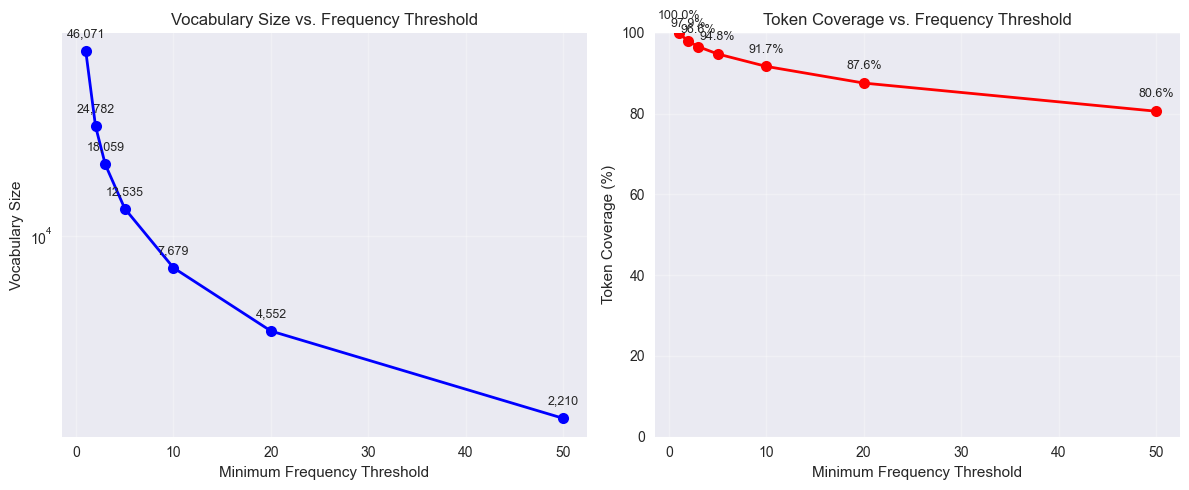

In [9]:
# Analysis specifically for language modeling preparation
print("🤖 Language Modeling Preparation Analysis:")
print("=" * 50)

# Vocabulary size recommendations for different frequency thresholds
freq_thresholds = [1, 2, 3, 5, 10, 20, 50]
vocab_sizes = []

print("📊 Vocabulary Size vs. Frequency Threshold:")
print("(Words occurring at least N times in training set)")
print("-" * 45)

for threshold in freq_thresholds:
    vocab_at_threshold = len([w for w, count in train_word_freq.items() if count >= threshold])
    vocab_sizes.append(vocab_at_threshold)
    coverage = sum(count for word, count in train_word_freq.items() if count >= threshold) / len(train_words) * 100
    print(f"Threshold ≥{threshold:2d}: {vocab_at_threshold:5,} words ({coverage:5.1f}% token coverage)")

# Visualize vocabulary size vs threshold
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(freq_thresholds, vocab_sizes, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Minimum Frequency Threshold')
plt.ylabel('Vocabulary Size')
plt.title('Vocabulary Size vs. Frequency Threshold')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Add value labels on points
for i, (threshold, size) in enumerate(zip(freq_thresholds, vocab_sizes)):
    plt.annotate(f'{size:,}', (threshold, size), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

plt.subplot(1, 2, 2)
# Calculate coverage for each threshold
coverages = []
for threshold in freq_thresholds:
    coverage = sum(count for word, count in train_word_freq.items() if count >= threshold) / len(train_words) * 100
    coverages.append(coverage)

plt.plot(freq_thresholds, coverages, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Minimum Frequency Threshold')
plt.ylabel('Token Coverage (%)')
plt.title('Token Coverage vs. Frequency Threshold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

# Add value labels
for i, (threshold, coverage) in enumerate(zip(freq_thresholds, coverages)):
    plt.annotate(f'{coverage:.1f}%', (threshold, coverage), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [10]:
# Sequence modeling considerations
print("\n🔗 Sequence Modeling Considerations:")
print("=" * 40)

# Analyze optimal sequence lengths for different percentiles
sequence_percentiles = [50, 75, 80, 85, 90, 95, 99]
print("📏 Recommended Maximum Sequence Lengths:")
print("(Based on sentence length percentiles)")
print("-" * 40)

for percentile in sequence_percentiles:
    max_length = int(np.percentile(train_lengths, percentile))
    sentences_covered = sum(1 for length in train_lengths if length <= max_length) / len(train_lengths) * 100
    print(f"{percentile:2d}th percentile: {max_length:3d} tokens ({sentences_covered:5.1f}% sentences covered)")

# Memory and computational considerations
print("\n💾 Memory and Computational Estimates:")
print("-" * 40)

recommended_vocab_sizes = [10000, 20000, 30000, 50000]
batch_sizes = [32, 64, 128]
sequence_lengths = [128, 256, 512]

print("Embedding matrix sizes (vocab_size × embedding_dim=512):")
for vocab_size in recommended_vocab_sizes:
    memory_mb = vocab_size * 512 * 4 / (1024 * 1024)  # 4 bytes per float32
    print(f"  {vocab_size:,} vocab: ~{memory_mb:.1f} MB")

print("\nBatch memory estimates (batch_size × seq_len × vocab_size × 4 bytes):")
for batch_size in batch_sizes:
    for seq_len in sequence_lengths:
        memory_gb = batch_size * seq_len * 30000 * 4 / (1024**3)  # Assuming 30K vocab
        print(f"  Batch {batch_size}, Seq {seq_len}: ~{memory_gb:.2f} GB")


🔗 Sequence Modeling Considerations:
📏 Recommended Maximum Sequence Lengths:
(Based on sentence length percentiles)
----------------------------------------
50th percentile: 289 tokens ( 50.0% sentences covered)
75th percentile: 800 tokens ( 75.0% sentences covered)
80th percentile: 948 tokens ( 80.0% sentences covered)
85th percentile: 1073 tokens ( 85.0% sentences covered)
90th percentile: 1224 tokens ( 90.0% sentences covered)
95th percentile: 1505 tokens ( 95.0% sentences covered)
99th percentile: 2199 tokens ( 99.0% sentences covered)

💾 Memory and Computational Estimates:
----------------------------------------
Embedding matrix sizes (vocab_size × embedding_dim=512):
  10,000 vocab: ~19.5 MB
  20,000 vocab: ~39.1 MB
  30,000 vocab: ~58.6 MB
  50,000 vocab: ~97.7 MB

Batch memory estimates (batch_size × seq_len × vocab_size × 4 bytes):
  Batch 32, Seq 128: ~0.46 GB
  Batch 32, Seq 256: ~0.92 GB
  Batch 32, Seq 512: ~1.83 GB
  Batch 64, Seq 128: ~0.92 GB
  Batch 64, Seq 256: ~1.83

## 7. Data Quality Assessment

In [11]:
# Data quality checks
print("✅ Data Quality Assessment:")
print("=" * 40)

def check_data_quality(sentences, words, name):
    """Perform comprehensive data quality checks."""
    issues = []
    
    # Check for empty sentences
    empty_sentences = sum(1 for s in sentences if not s.strip())
    if empty_sentences > 0:
        issues.append(f"Found {empty_sentences} empty sentences")
    
    # Check for very short sentences (< 3 words)
    short_sentences = sum(1 for s in sentences if len(s.split()) < 3)
    if short_sentences > 0:
        issues.append(f"Found {short_sentences} very short sentences (<3 words)")
    
    # Check for very long sentences (> 200 words)
    long_sentences = sum(1 for s in sentences if len(s.split()) > 200)
    if long_sentences > 0:
        issues.append(f"Found {long_sentences} very long sentences (>200 words)")
    
    # Check for unusual characters
    unusual_chars = set()
    for word in words[:1000]:  # Sample first 1000 words
        for char in word:
            if ord(char) > 127:  # Non-ASCII
                unusual_chars.add(char)
    
    if unusual_chars:
        issues.append(f"Found non-ASCII characters: {list(unusual_chars)[:10]}")
    
    # Check EOS token consistency
    sentences_with_eos = sum(1 for s in sentences if s.strip().endswith('<eos>'))
    eos_coverage = sentences_with_eos / len(sentences) * 100
    
    print(f"\n📋 {name} Quality Report:")
    print(f"  • Total sentences: {len(sentences):,}")
    print(f"  • Sentences with <eos>: {sentences_with_eos:,} ({eos_coverage:.1f}%)")
    print(f"  • Average sentence length: {np.mean([len(s.split()) for s in sentences]):.1f} words")
    print(f"  • Unique words: {len(set(words)):,}")
    
    if issues:
        print(f"  ⚠️  Issues found:")
        for issue in issues:
            print(f"    - {issue}")
    else:
        print(f"  ✅ No quality issues detected")
    
    return len(issues) == 0

# Check quality for each split
train_quality = check_data_quality(train_sentences, train_words, 'TRAINING')
valid_quality = check_data_quality(valid_sentences, valid_words, 'VALIDATION')
test_quality = check_data_quality(test_sentences, test_words, 'TEST')

print(f"\n🏆 Overall Data Quality: {'✅ PASSED' if all([train_quality, valid_quality, test_quality]) else '⚠️ ISSUES FOUND'}")

✅ Data Quality Assessment:

📋 TRAINING Quality Report:
  • Total sentences: 2,000
  • Sentences with <eos>: 2,000 (100.0%)
  • Average sentence length: 512.9 words
  • Unique words: 46,071
  ⚠️  Issues found:
    - Found 1204 very long sentences (>200 words)

📋 VALIDATION Quality Report:
  • Total sentences: 100
  • Sentences with <eos>: 100 (100.0%)
  • Average sentence length: 600.2 words
  • Unique words: 8,475
  ⚠️  Issues found:
    - Found 62 very long sentences (>200 words)

📋 TEST Quality Report:
  • Total sentences: 100
  • Sentences with <eos>: 100 (100.0%)
  • Average sentence length: 569.2 words
  • Unique words: 8,443
  ⚠️  Issues found:
    - Found 73 very long sentences (>200 words)

🏆 Overall Data Quality: ⚠️ ISSUES FOUND


## 8. Summary and Recommendations

In [12]:
# Generate comprehensive summary and recommendations
print("📋 PENN TREEBANK DATASET ANALYSIS SUMMARY")
print("=" * 60)

print("\n📊 DATASET OVERVIEW:")
print(f"  • Training sentences: {len(train_sentences):,}")
print(f"  • Validation sentences: {len(valid_sentences):,}")
print(f"  • Test sentences: {len(test_sentences):,}")
print(f"  • Total tokens: {len(train_words) + len(valid_words) + len(test_words):,}")
print(f"  • Vocabulary size (combined): {len(set(train_words + valid_words + test_words)):,}")

print("\n🎯 KEY CHARACTERISTICS:")
print(f"  • Average sentence length: {np.mean(train_lengths):.1f} words")
print(f"  • Median sentence length: {np.median(train_lengths):.1f} words")
print(f"  • 95th percentile length: {np.percentile(train_lengths, 95):.0f} words")
print(f"  • Vocabulary coverage (valid): {train_valid_overlap:.1f}%")
print(f"  • Vocabulary coverage (test): {train_test_overlap:.1f}%")

print("\n🚀 RECOMMENDATIONS FOR LANGUAGE MODELING:")
print("-" * 50)

# Vocabulary recommendations
optimal_vocab_size = len([w for w, count in train_word_freq.items() if count >= 3])
print(f"\n📚 VOCABULARY:")
print(f"  • Recommended vocab size: {optimal_vocab_size:,} words (freq ≥ 3)")
print(f"  • This covers {sum(count for word, count in train_word_freq.items() if count >= 3) / len(train_words) * 100:.1f}% of training tokens")
print(f"  • Consider using <UNK> token for rare words")
print(f"  • Include special tokens: <EOS>, <UNK>, <PAD>")

# Sequence length recommendations
recommended_seq_len = int(np.percentile(train_lengths, 90))
print(f"\n📏 SEQUENCE LENGTH:")
print(f"  • Recommended max sequence length: {recommended_seq_len} tokens")
print(f"  • This covers {sum(1 for length in train_lengths if length <= recommended_seq_len) / len(train_lengths) * 100:.1f}% of training sentences")
print(f"  • Consider truncation/padding for longer sequences")

# Model architecture suggestions
print(f"\n🏗️ MODEL ARCHITECTURE SUGGESTIONS:")
print(f"  • Embedding dimension: 512 or 768")
print(f"  • Hidden size: 1024 or 1536")
print(f"  • Number of layers: 6-12 for Transformer, 2-4 for LSTM")
print(f"  • Attention heads (Transformer): 8 or 12")
print(f"  • Dropout: 0.1-0.3")

# Training recommendations
print(f"\n🎯 TRAINING RECOMMENDATIONS:")
print(f"  • Batch size: 32-128 (depending on GPU memory)")
print(f"  • Learning rate: 1e-4 to 5e-4 (with warmup)")
print(f"  • Gradient clipping: 1.0")
print(f"  • Validation frequency: Every 1000-2000 steps")
print(f"  • Early stopping patience: 3-5 evaluations")

# Evaluation metrics
print(f"\n📈 EVALUATION METRICS:")
print(f"  • Primary: Perplexity on validation/test sets")
print(f"  • Secondary: BLEU score for text generation")
print(f"  • Monitor: Training loss, gradient norms")

print(f"\n" + "=" * 60)
print(f"✅ Dataset is ready for language modeling experiments!")
print(f"📁 Processed files saved in: data/ptb/")
print(f"🚀 Next steps: Implement tokenization and model training pipeline")

📋 PENN TREEBANK DATASET ANALYSIS SUMMARY

📊 DATASET OVERVIEW:
  • Training sentences: 2,000
  • Validation sentences: 100
  • Test sentences: 100
  • Total tokens: 1,142,804
  • Vocabulary size (combined): 48,233

🎯 KEY CHARACTERISTICS:
  • Average sentence length: 512.9 words
  • Median sentence length: 289.5 words
  • 95th percentile length: 1505 words
  • Vocabulary coverage (valid): 86.6%
  • Vocabulary coverage (test): 87.4%

🚀 RECOMMENDATIONS FOR LANGUAGE MODELING:
--------------------------------------------------

📚 VOCABULARY:
  • Recommended vocab size: 18,059 words (freq ≥ 3)
  • This covers 96.6% of training tokens
  • Consider using <UNK> token for rare words
  • Include special tokens: <EOS>, <UNK>, <PAD>

📏 SEQUENCE LENGTH:
  • Recommended max sequence length: 1224 tokens
  • This covers 90.0% of training sentences
  • Consider truncation/padding for longer sequences

🏗️ MODEL ARCHITECTURE SUGGESTIONS:
  • Embedding dimension: 512 or 768
  • Hidden size: 1024 or 1536
  •

## 9. Export Analysis Results

In [13]:
# Save analysis results for future reference
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

# Save statistics
stats_df.to_csv(results_dir / 'ptb_dataset_statistics.csv')
patterns_df.to_csv(results_dir / 'ptb_pattern_analysis.csv')
length_stats_df.to_csv(results_dir / 'ptb_length_statistics.csv')

# Save vocabulary information
vocab_info = {
    'total_vocab_size': len(combined_word_freq),
    'train_vocab_size': len(train_word_freq),
    'recommended_vocab_size': optimal_vocab_size,
    'recommended_seq_length': recommended_seq_len,
    'train_valid_overlap': train_valid_overlap,
    'train_test_overlap': train_test_overlap
}

import json
with open(results_dir / 'ptb_analysis_summary.json', 'w') as f:
    json.dump(vocab_info, f, indent=2)

print("📊 Analysis results saved to:")
print(f"  • {results_dir / 'ptb_dataset_statistics.csv'}")
print(f"  • {results_dir / 'ptb_pattern_analysis.csv'}")
print(f"  • {results_dir / 'ptb_length_statistics.csv'}")
print(f"  • {results_dir / 'ptb_analysis_summary.json'}")

print("\n🎉 Exploratory Data Analysis Complete!")
print("📝 This notebook can be rerun anytime to regenerate the analysis.")

📊 Analysis results saved to:
  • ..\results\ptb_dataset_statistics.csv
  • ..\results\ptb_pattern_analysis.csv
  • ..\results\ptb_length_statistics.csv
  • ..\results\ptb_analysis_summary.json

🎉 Exploratory Data Analysis Complete!
📝 This notebook can be rerun anytime to regenerate the analysis.
